# Lab 4 - Acquiring data from the web in Python

In this lab, we will interact with a few APIs to get a feel for how they work and how you can make the most of them when trying to access data on the web. To follow this session, you will need to be able to access the following:

- The internet
- A Python installation such as the "Geographic Data Science Stack 2019" in the University of Liverpool computers, or the `gds_env` Docker container in your own machine (see [here](http://darribas.org/gds19/software.html) for instructions) 
- A Mapbox API token, which you can access through your Mapbox account

In [1]:
%matplotlib inline
from IPython.display import IFrame

import contextily as cx
import geopandas
import json
import matplotlib.pyplot as plt
import mercantile
import pandas
import requests

## UK Police API

**First pass**

In [2]:
IFrame("https://data.police.uk/docs/", 300, 150)

Let's look for crime events by location. For example, we can take December of 2019 on a given location (`53.40146` lat and `-2.96459` lon) and build the query:

In [3]:
url = ('https://data.police.uk/api/outcomes-at-location?'\
       'date=2019-12&lat=53.40146&lng=-2.96459')
url

'https://data.police.uk/api/outcomes-at-location?date=2019-12&lat=53.40146&lng=-2.96459'

You can check on your browser manually if this works:

In [4]:
IFrame(url, 300, 150)

Now we'll access it programmatically using `requests` (the %time is a python "magic function" to time a particular piece of code) :

In [5]:
%time r = requests.get(url)

Wall time: 317 ms


In [7]:
# First 100 characters only
r.content[:100]

b'[{"category":{"code":"no-further-action","name":"Investigation complete; no suspect identified"},"da'

This is encoded in bytes, we need to decode it into a string and convert it into a data structure that we can work with.

In [8]:
crimes = json.loads(r.content)

In [9]:
type(crimes)

list

In [10]:
len(crimes)

1316

In [11]:
crimes[0]

{'category': {'code': 'no-further-action',
  'name': 'Investigation complete; no suspect identified'},
 'date': '2019-12',
 'person_id': None,
 'crime': {'category': 'theft-from-the-person',
  'location_type': 'Force',
  'location': {'latitude': '53.403000',
   'street': {'id': 910327, 'name': 'On or near Fleet Street'},
   'longitude': '-2.980079'},
  'context': '',
  'persistent_id': 'cc8b7d1a0c213a4c5233ce6b1021df38f19cd2a4faa3278d2d166f84cf5f6e32',
  'id': 80010641,
  'location_subtype': 'ROAD',
  'month': '2019-12'}}

Now this looks more Pythonic! Let's convert it into a `pandas.DataFrame`:

In [12]:
crimes_db = pandas.DataFrame(crimes)
crimes_db.head()

,category,date,person_id,crime
0,"{'code': 'no-further-action', 'name': 'Investi...",2019-12,None,"{'category': 'theft-from-the-person', 'locatio..."
1,"{'code': 'unable-to-prosecute', 'name': 'Unabl...",2019-12,None,"{'category': 'violent-crime', 'location_type':..."
2,"{'code': 'court-result-unavailable', 'name': '...",2020-06,None,"{'category': 'violent-crime', 'location_type':..."
3,"{'code': 'unable-to-prosecute', 'name': 'Unabl...",2019-12,None,"{'category': 'public-order', 'location_type': ..."
4,"{'code': 'unable-to-prosecute', 'name': 'Unabl...",2019-12,None,"{'category': 'shoplifting', 'location_type': '..."


Now, for some applications this might be fine and we'd be good to go. For mapping however, this does not give us a working location. The reason is that the output from the API is more complex than a flat dictionary.

In [12]:
crimes[0]

{'category': {'code': 'no-further-action',
  'name': 'Investigation complete; no suspect identified'},
 'date': '2019-12',
 'person_id': None,
 'crime': {'category': 'theft-from-the-person',
  'location_type': 'Force',
  'location': {'latitude': '53.403000',
   'street': {'id': 910327, 'name': 'On or near Fleet Street'},
   'longitude': '-2.980079'},
  'context': '',
  'persistent_id': 'cc8b7d1a0c213a4c5233ce6b1021df38f19cd2a4faa3278d2d166f84cf5f6e32',
  'id': 80010641,
  'location_subtype': 'ROAD',
  'month': '2019-12'}}

To pull out the lon/lat coordinates, we need to drill deeper into the `location` entry, which is within the `crime` bit:

In [13]:
crimes[0]["crime"]["location"]

{'latitude': '53.403000',
 'street': {'id': 910327, 'name': 'On or near Fleet Street'},
 'longitude': '-2.980079'}

---

**Parsing a single crime event**

For convenience, let's pull out a single crime:

In [14]:
cr = crimes[0]
cr

{'category': {'code': 'no-further-action',
  'name': 'Investigation complete; no suspect identified'},
 'date': '2019-12',
 'person_id': None,
 'crime': {'category': 'theft-from-the-person',
  'location_type': 'Force',
  'location': {'latitude': '53.403000',
   'street': {'id': 910327, 'name': 'On or near Fleet Street'},
   'longitude': '-2.980079'},
  'context': '',
  'persistent_id': 'cc8b7d1a0c213a4c5233ce6b1021df38f19cd2a4faa3278d2d166f84cf5f6e32',
  'id': 80010641,
  'location_subtype': 'ROAD',
  'month': '2019-12'}}

In [15]:
cr.keys()

dict_keys(['category', 'date', 'person_id', 'crime'])

Let's say, for every crime event, we want to keep the following attributes:

- Category code
- Crime ID, category, and location (lon/lat, as a geometry)
- Date
- Location type and subtype

Manually, we can extract those bits into a `Series` object:

In [16]:
cr_parsed = pandas.Series({
       'category_code': cr['category']['code'],\
       'crime_category': cr['crime']['category'], \
       'cime_id': cr['crime']['id'],\
       'cime_category': cr['crime']['category'], \
       'longitude': float(cr['crime']['location']['longitude']), \
       'latitude': float(cr['crime']['location']['latitude']), \
       'date': cr['crime']['month'], \
       'crime_location_type': cr['crime']['location_type'], \
       'crime_location_subtype': cr['crime']['location_subtype']
                  })
cr_parsed

category_code                 no-further-action
crime_category            theft-from-the-person
cime_id                                80010641
cime_category             theft-from-the-person
longitude                              -2.98008
latitude                                 53.403
date                                    2019-12
crime_location_type                       Force
crime_location_subtype                     ROAD
dtype: object

One way to move into a more automated version is to turn the above into a small function:

In [17]:
def parse_crime_event(cr):
    cr_parsed = pandas.Series({
           'category_code': cr['category']['code'],\
           'crime_category': cr['crime']['category'], \
           'cime_id': cr['crime']['id'],\
           'cime_category': cr['crime']['category'], \
           'longitude': float(cr['crime']['location']['longitude']), \
           'latitude': float(cr['crime']['location']['latitude']), \
           'date': cr['crime']['month'], \
           'crime_location_type': cr['crime']['location_type'], \
           'crime_location_subtype': cr['crime']['location_subtype']
                      })
    return cr_parsed

Which means we can use it on any crime event with the same structure:

In [18]:
parse_crime_event(cr)

category_code                 no-further-action
crime_category            theft-from-the-person
cime_id                                80010641
cime_category             theft-from-the-person
longitude                              -2.98008
latitude                                 53.403
date                                    2019-12
crime_location_type                       Force
crime_location_subtype                     ROAD
dtype: object

In [19]:
parse_crime_event(crimes[10])

category_code             unable-to-prosecute
crime_category                  violent-crime
cime_id                              79309151
cime_category                   violent-crime
longitude                            -2.98489
latitude                              53.4086
date                                  2019-11
crime_location_type                     Force
crime_location_subtype                   ROAD
dtype: object

To note:

* It works because argument is `cr` and the `cr` object is used throughout
* A function (method) can be applied in any context where the object passed as `cr` (it doesn't need to be named that way) meets the expectations of the method (ie. has all the attributes it expects)

---

**Extending to all crimes in the batch**

Armed with the function above, we can apply it to all the crimes in our initial batch. For this, we will use a `for` loop:

In [20]:
# Start an empty list to store parsed crimes dynamically
parsed = []

# Loop over each crime event in the list of crimes
for cr in crimes:
    # Parse a single crime
    pc = parse_crime_event(cr)
    # Store the parsed crime into the list created
    parsed.append(pc)

# Conver the list into a DataFrame
parsed = pandas.DataFrame(parsed)

In [21]:
parsed.head()

,category_code,crime_category,cime_id,cime_category,longitude,latitude,date,crime_location_type,crime_location_subtype
0,no-further-action,theft-from-the-person,80010641,theft-from-the-person,-2.980079,53.403000,2019-12,Force,ROAD
1,unable-to-prosecute,violent-crime,77666055,violent-crime,-2.964809,53.409497,2019-09,Force,HOSPITALS
2,court-result-unavailable,violent-crime,79311446,violent-crime,-2.974566,53.409256,2019-11,Force,ROAD
3,unable-to-prosecute,public-order,80005371,public-order,-2.946783,53.403259,2019-12,Force,SUPERMARKET CHAINS
4,unable-to-prosecute,shoplifting,80012712,shoplifting,-2.985119,53.403704,2019-12,Force,PARKING


Now, to complete the job and be able to work with these data in a (web) mapping environment, we need to turn lon/lat coordinates into geometries. For that, we will rely on `geopandas` (see [here](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html) for more detail).

In [22]:
points = geopandas.points_from_xy(parsed["longitude"],
                                  parsed["latitude"]
                                 )
geo_db = geopandas.GeoDataFrame(parsed,
                                geometry=points,
                                crs="EPSG:4326"
                               )

<AxesSubplot:>

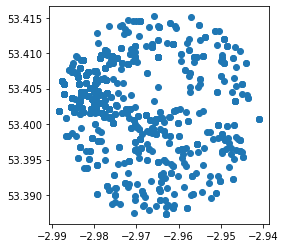

In [23]:
geo_db.plot()

---

**Exercise** Explore the API for ["Stop and search" by area](https://data.police.uk/docs/method/stops-street/) data from the Police API and try to obtain data through it. Specifically try:

1. Request data using the "Specific point" endpoint to pull down a batch of data around the [Roxby Building](https://osm.org/go/euf9JF7EW?m=).
1. For the API ninjas out there (ie. optional), try to extract data using the "Custom area" endpoint. For example, create a polygon using [`geojson.net`](https://osm.org/go/euf9JF7EW?m=) and query data available within the polygon.

---

## Basemaps API

This section will cover the access of basemaps served as tilesets through the standard XYZ protocol. For this, we will use the `contextily` library, first as end-users, and then we will peak a bit into its guts to get a better understanding of its inner workings.

The XYZ protocol exposes maps as images for portions of the Earth we will call tiles. The XYZ name stands from the "coordinates" used to locate a given tile. This of the entire planet split up into squares, each of them available with a unique combination of X and Y numbers. Now add a third one (Z) for the zoom level: lower values use less tiles to cover the world, while higher resolution levels (higher Z) will cover progressively smaller areas, but with more detail.

Most XYZ APIs expose tiles directly over HTTP, which means we can access them from the browser. A handy tool in this context is the [`mercantile`](https://github.com/mapbox/mercantile) library, which handles conversions from lon/lat coordinates into tiles. For example, to get the tile XYZ for the coordinates we used above, a zoom level 12, we can run:

In [24]:
mercantile.tile(-2.96459, 53.40146, 11)

Tile(x=1007, y=663, z=11)

We can access now the [Stamen Terrain](http://maps.stamen.com/terrain/#12/53.3937/-2.9503) tile for that tile:

In [25]:
tile_url = (
    "http://tile.stamen.com/terrain/11/1007/663.jpg"
)
tile_url

'http://tile.stamen.com/terrain/11/1007/663.jpg'

In [26]:
IFrame(tile_url, 300, 300)

Now, to make a full basemap of an arbitrary extent at a given zoom level, we would need to identify all the tiles required, collect them, and compose a map that stitches them into a continuous mosaic. Luckily for us, the `contextily` library does exactly that for us. There are two different ways of using it.

First, the easy way. The most straightforward way to make a basemap with `contextily` is to provide a `GeoDataFrame`, plot it, and the add a basemap in a given CRS. For example, let's used the `geo_db` table from the Police API:

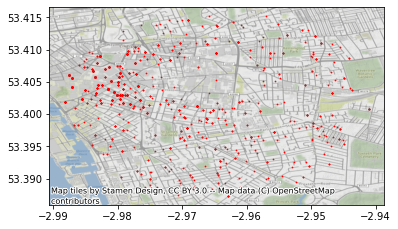

In [27]:
ax = geo_db.plot(markersize=0.5, color='red')
cx.add_basemap(ax, crs=geo_db.crs)

---

**Exercise** The `contextily.providers` module provides access to several tile providers:

In [28]:
cx.providers.keys()

dict_keys(['OpenStreetMap', 'OpenSeaMap', 'OpenPtMap', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Thunderforest', 'OpenMapSurfer', 'Hydda', 'MapBox', 'Stamen', 'Esri', 'OpenWeatherMap', 'HERE', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'Wikimedia', 'GeoportailFrance', 'OneMapSG'])

To swap the default for a particular provider, you need to use the `url` attribute. For example, to use CARTO instead of Stamen:

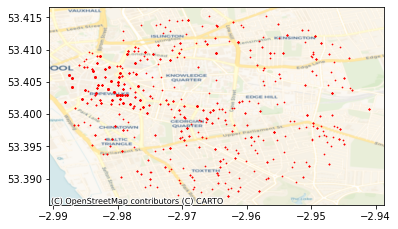

In [29]:
ax = geo_db.plot(markersize=0.5, color='red')
cx.add_basemap(
    ax, 
    crs=geo_db.crs,
    source=cx.providers.CartoDB.Voyager,
    zoom=14
)

TIP:  When adding the basemap, in newer versions you may be getting an error in loading the map, 
use:

```url=cx.providers.CartoDB.Voyager```

instead of

``source=cx.providers.CartoDB.Voyager.``

Explore the different providers and create similar maps as above using them.

---

Second, the flexible way. Sometimes, we don't necessarily have a layer to plot under, or we want to have a bit more control over what we actually pull down. For these cases, we'll swap `add_basemap` for `bounds2img`, which allows us to pass an arbitrary bounding box and retrieve a stitched up tile.

For example, we will replicate the basemap above:

In [30]:
geo_db.total_bounds

array([-2.98822 , 53.387346, -2.941042, 53.415206])

In [31]:
w, s, e, n = geo_db.total_bounds

With the bounding box, we can pull down the image (and its extent):

In [32]:
img, ext = cx.bounds2img(w, s, e, n, ll=True)

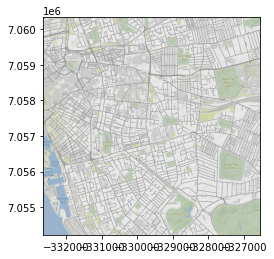

In [33]:
plt.imshow(img, extent=ext)

A final trick that `contextily` has under its hand is the ability to write a basemap into a `.tiff` file so we can access it in a standard GIS, such as QGIS. The interface is the same as in `bounds2img`, but in this case, we will be calling `bounds2raster`:

In [34]:
img, ext = cx.bounds2raster(
    w, s, e, n, "my_basemap.tif", ll=True
)

Fire up QGIS and inspect the file we've just created (`my_basemap.tif`).

## Directions API

To finish this lab, we will explore an API that allows us to tap into the output of computations that take place in the cloud, rather than a direct database. In particular, we will play witht he [Mapbox Directions API](https://docs.mapbox.com/api/navigation/#directions). For accesing Mapbox services, you will need your token handy. The way we read it in here assumes you have a file called `MAPBOX_TOKEN` in the same folder as this notebook:

In [35]:
TOKEN = open("MAPBOX_TOKEN").read().strip("\n")

The Directions API allows us to retrieve routing directions for different travel modes from two points. The general structure of the call is as follows:

In [36]:
dir_base = (
    "https://api.mapbox.com/directions/v5/mapbox/"\
    "XXXmodeXXX/"\
    "XXXorig_lonXXX,XXXorig_latXXX;"\
    "XXXdest_lonXXX,XXXdest_latXXX"\
    "?geometries=geojson"\
    "&access_token=YOUR_MAPBOX_ACCESS_TOKEN"
)
dir_base

'https://api.mapbox.com/directions/v5/mapbox/XXXmodeXXX/XXXorig_lonXXX,XXXorig_latXXX;XXXdest_lonXXX,XXXdest_latXXX?geometries=geojson&access_token=YOUR_MAPBOX_ACCESS_TOKEN'

Now to build an actual query, we need to replace each parameter by a value. There are several ways of doing this, one possible one is:

In [37]:
query = dir_base.replace("XXXmodeXXX", "walking")\
                .replace("XXXorig_lonXXX", "-2.8857242")\
                .replace("XXXorig_latXXX", "53.3803881")\
                .replace("XXXdest_lonXXX", "-2.9146053")\
                .replace("XXXdest_latXXX", "53.3882099")
query

'https://api.mapbox.com/directions/v5/mapbox/walking/-2.8857242,53.3803881;-2.9146053,53.3882099?geometries=geojson&access_token=YOUR_MAPBOX_ACCESS_TOKEN'

For the real query, we will also include our own token stored in `TOKEN`. Other than that, we're all set! We can ask for the data in similar ways as above:

In [38]:
r = requests.get(query.replace("YOUR_MAPBOX_ACCESS_TOKEN", TOKEN))

We can examine the response:

In [39]:
# Blurb too long, reading only first 100 characters
r.content

b'{"routes":[{"weight_name":"pedestrian","weight":1658.645,"duration":1615.194,"distance":2287.895,"legs":[{"admins":[{"iso_3166_1_alpha3":"GBR","iso_3166_1":"GB"}],"weight":1658.645,"duration":1615.194,"steps":[],"distance":2287.895,"summary":"A562, A5058"}],"geometry":{"coordinates":[[-2.885599,53.380121],[-2.886148,53.379975],[-2.889188,53.381962],[-2.893808,53.384666],[-2.898128,53.385703],[-2.899882,53.386321],[-2.909303,53.388118],[-2.909476,53.388095],[-2.909853,53.388049],[-2.910888,53.387915],[-2.911719,53.388324],[-2.913846,53.388725],[-2.91392,53.388593],[-2.91462,53.38822]],"type":"LineString"}}],"waypoints":[{"distance":30.89,"name":"Beaconsfield Road","location":[-2.885599,53.380121]},{"distance":1.46,"name":"Carsdale Road","location":[-2.91462,53.38822]}],"code":"Ok","uuid":"n4aPqd53fWqIAsFlzL2_cGsaahfXJqr8Dv1Lf3LMpMWyJ0LApljg1A=="}'

But, to make more sense, we can pass it through the `json` library:

In [40]:
waypoints = json.loads(r.content)
waypoints

{'routes': [{'weight_name': 'pedestrian',
   'weight': 1658.645,
   'duration': 1615.194,
   'distance': 2287.895,
   'legs': [{'admins': [{'iso_3166_1_alpha3': 'GBR', 'iso_3166_1': 'GB'}],
     'weight': 1658.645,
     'duration': 1615.194,
     'steps': [],
     'distance': 2287.895,
     'summary': 'A562, A5058'}],
   'geometry': {'coordinates': [[-2.885599, 53.380121],
     [-2.886148, 53.379975],
     [-2.889188, 53.381962],
     [-2.893808, 53.384666],
     [-2.898128, 53.385703],
     [-2.899882, 53.386321],
     [-2.909303, 53.388118],
     [-2.909476, 53.388095],
     [-2.909853, 53.388049],
     [-2.910888, 53.387915],
     [-2.911719, 53.388324],
     [-2.913846, 53.388725],
     [-2.91392, 53.388593],
     [-2.91462, 53.38822]],
    'type': 'LineString'}}],
 'waypoints': [{'distance': 30.89,
   'name': 'Beaconsfield Road',
   'location': [-2.885599, 53.380121]},
  {'distance': 1.46,
   'name': 'Carsdale Road',
   'location': [-2.91462, 53.38822]}],
 'code': 'Ok',
 'uuid': '

Phew! That returns a fully formed, nicely formatted object with all the info we need. There is a lot of information there. For now, we will parse only the direction line that connects directions. For that, we need to do a bit of fiddling again. The basics are relatively straightforward, but "the devil is always in the details"!

In [41]:
route = waypoints['routes'][0]
route['properties'] = {"distance": waypoints["routes"][0]["distance"],
                       "duration": waypoints["routes"][0]["duration"]
                      }
routes = geopandas.GeoDataFrame.from_features([route], crs="EPSG:4326")
routes

,geometry,distance,duration
0,"LINESTRING (-2.88560 53.38012, -2.88615 53.379...",2287.895,1615.194


With this, we can make a map just as above:

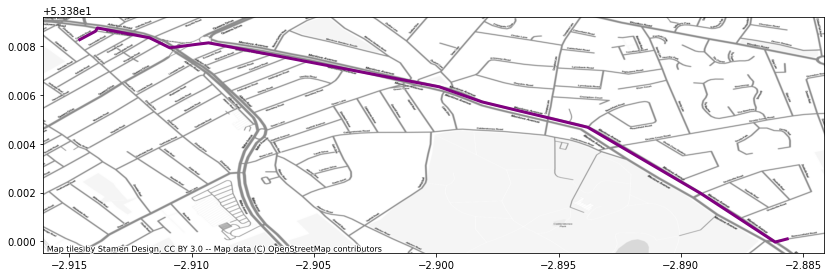

In [42]:
ax = routes.plot(color="purple", linewidth=3, figsize=(14, 14))
cx.add_basemap(ax, crs=routes.crs, source=cx.providers.Stamen.TonerLite)

---

**Exercise** Explore the documentation for the [isochrone API](https://docs.mapbox.com/api/navigation/#isochrone) and try to obtain results. For example, retrieve the area that can be reached within 15 minutes of the Roxby Building.

---

**Exercise (II)** Explore the documentation for the [geocoding API](https://docs.mapbox.com/api/search/#geocoding) and try to use it to automatically embed coordinates between addresses.

---